In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm
import pandas as pd

In [3]:
# hyper-parameters
ROOT_FOLDER = "..\.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [4]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [5]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [6]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return tf.reduce_mean(-np.mean(term_0+term_1, axis=0))

In [7]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [8]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [9]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
#anomalies = [x.reshape(128, 128, 1) for x in anomalies]

In [10]:
# gather the unseen testing data set

test_normals, _ = create_dataset(processed_data=True, train=False, anomaly=False)
test_normals, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_normals, split = False)

test_anomalies, _ = create_dataset(processed_data=True, train=False, anomaly=True)
test_anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_anomalies, split = False)

In [43]:
# build model

# input size is (128, 128). That means the input is 16.384 floats. In the input below they have an input of 784.
input_shape = (128, 128, 1)

"""
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
"""

inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)

# "encoded" is the encoded representation of the input
encoded = layers.Dense(64, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(1, activation='sigmoid')(encoded)

outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()


history = autoencoder.fit(train_data, train_data,
                epochs=5,
                batch_size=10,
                shuffle=True,
                validation_data=(val_data, val_data),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 128, 128, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
                                                                 
 dense_14 (Dense)            (None, 128, 128, 64)      2112      
                                                                 
 dense_15 (Dense)            (None, 128, 128, 1)       65        
                                                          

In [44]:
autoencoder.save('../../models/v1-3x.h5')

In [18]:
autoencoder = tf.keras.models.load_model('../../models/v1-3.h5')

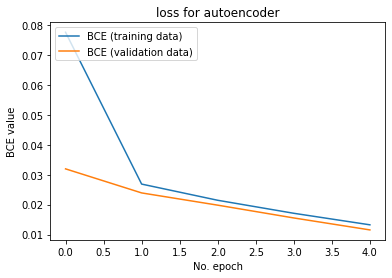

In [45]:
# Plot history: loss
plt.plot(history.history['loss'], label='BCE (training data)')
plt.plot(history.history['val_loss'], label='BCE (validation data)')
plt.title('loss for autoencoder')
plt.ylabel('BCE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [14]:
decoded_mnistimgs = []

for i in range(n):

    decoded_imgs.append(autoencoder.predict(test_data[i]))

    

In [42]:
autoencoder.predict(test_data[i]).shape

(128, 128, 1, 1)

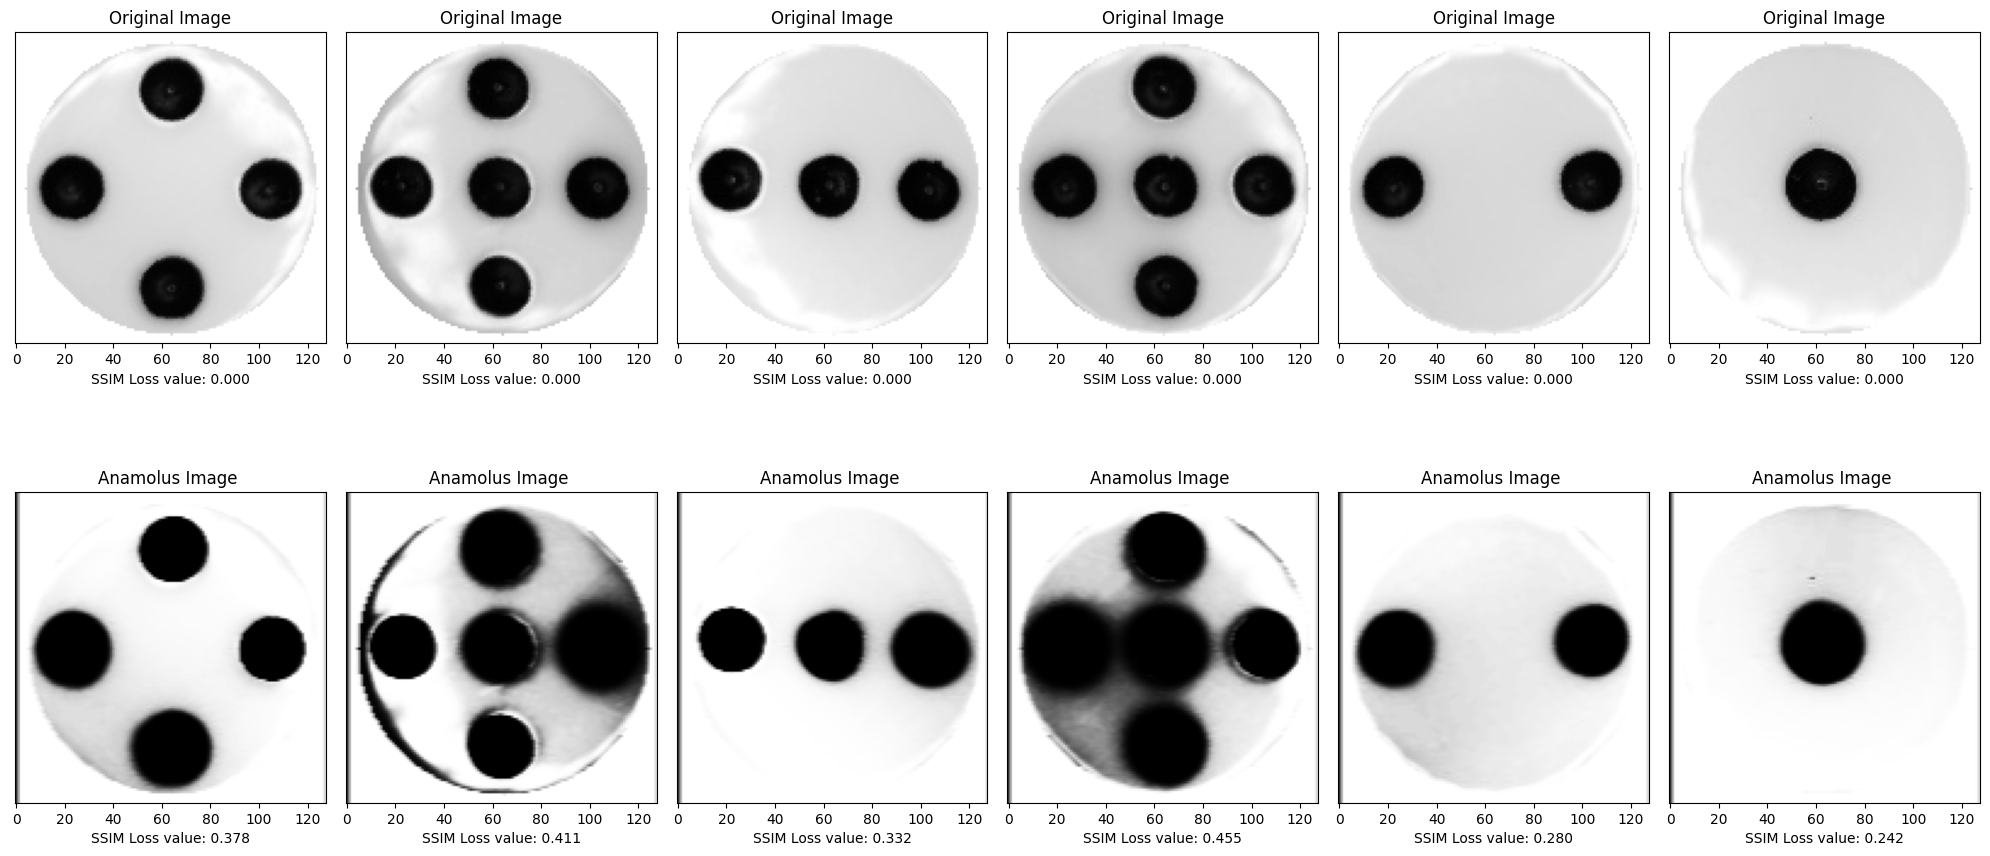

In [46]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):

    decoded_imgs.append(autoencoder.predict(test_data[i]))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

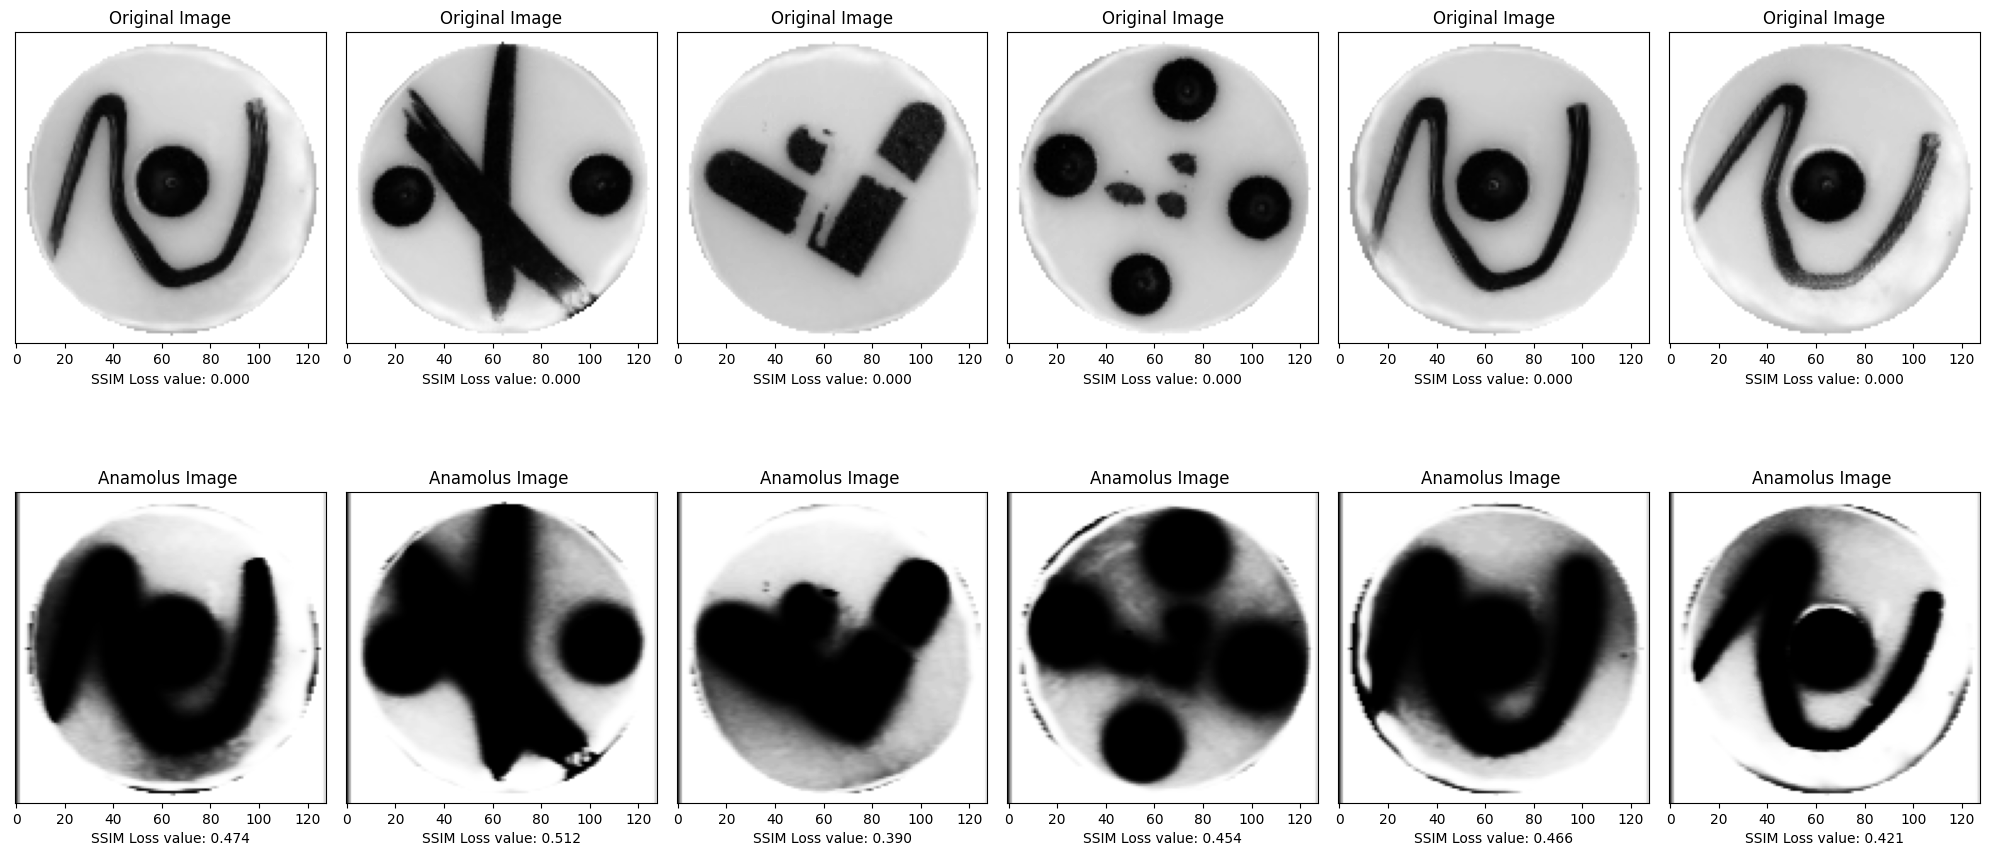

In [47]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):

    decoded_mnistimgs.append(autoencoder.predict(anomalies[i]))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(anomalies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(anomalies[i], anomalies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_mnistimgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, anomalies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

In [50]:
# evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_stats(predictions, labels):
  print("f1 = {}".format(f1_score(labels, predictions)))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

def predictor(ano_pred, norm_pred, threshold):
    threshold = np.float32(threshold)
    predictions = []
    labels = []

    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)


    return predictions, labels


In [54]:
ano_predictions = []

for ano in test_anomalies:

    result = autoencoder.predict(ano).reshape(128,128,1)

    ano_predictions.append(SSIMLoss(ano, result).numpy())

In [55]:
norm_predictions = []

for sample in tqdm.tqdm(test_normals):

    result = autoencoder.predict(sample).reshape(128,128,1)

    norm_predictions.append(SSIMLoss(sample, result).numpy())

100%|██████████| 330/330 [00:42<00:00,  7.79it/s]


In [51]:
threshold = np.mean([np.mean(norm_predictions), np.mean(ano_predictions)])
threshold

0.38338143

In [52]:
predictions, labels = predictor(ano_predictions, norm_predictions, threshold)

In [53]:
print_stats(predictions, labels)

f1 = 0.22522522522522523
Accuracy = 0.7490882567469
Precision = 0.12886597938144329
Recall = 0.8928571428571429


In [56]:
# predicting for the anomalies in the testing set

ano_predictions_t = []
norm_predictions_t = []

for ano in test_anomalies:

    result = autoencoder.predict(ano).reshape(128,128,1)

    ano_predictions_t.append(SSIMLoss(ano, result))

for sample in tqdm.tqdm(test_normals):

    result = autoencoder.predict(sample).reshape(128,128,1)

    norm_predictions_t.append(SSIMLoss(sample, result).numpy())

predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold)
print_stats(predictions, labels)

100%|██████████| 330/330 [00:41<00:00,  7.96it/s]

f1 = 0.21052631578947367
Accuracy = 0.5365168539325843
Precision = 0.12021857923497267
Recall = 0.8461538461538461
